## Chapter6 VGGNet 
### VGG11 

#### 필요한 라이브러리 호출

In [2]:
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

#### VGG 모델 정의

In [3]:
class VGG(nn.Module):
    def __init__(self,features,output_dim):
        super().__init__()
        self.features = features # VGG모델에 대한 매개 변수에서 받아온 features값을 넣어줌 
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096,output_dim)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

#### 모델 유형 정의

In [4]:
vgg11_config = [64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M']

vgg13_config = [64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M']

vgg16_config = [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']

vgg19_config = [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']

#### VGG 계층 정의

In [5]:
def get_vgg_layers(config,batch_norm):
    layers = []
    in_channels = 3
    
    for c in config:
        assert c =='M' or isinstance(c,int) # True 가 아니면 error 발생 c == M 이 아니면 오류 발생 
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels,c,kernel_size=3,padding=1)
            if batch_norm:
                layers +=[conv2d,nn.BatchNorm2d(c),nn.ReLU(inplace=True)]
            else:
                layers += [conv2d,nn.ReLU(inplace=True)]
            in_channels = c 
    return nn.Sequential(*layers)

#### 모델 계층 생성

In [6]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

#### VGG11 계층 확인

In [7]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

#### VGG11 전체에 대한 네트워크 

In [8]:
OUTPUT_DIM = 2
model = VGG(vgg11_layers,OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

#### VGG11 사전 훈련 모델 사용

In [9]:
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained = True)
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

#### 이미지 데이터 전처리

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224,.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224,.225])
    
])

#### ImageFolder를 이용하여 데이터셋 불러오기 

In [11]:
train_path = "C:/Users/CoIn241/Desktop/chan/torchbook_data/chap06/data/catanddog/train"
test_path = "C:/Users/CoIn241/Desktop/chan/torchbook_data/chap06/data/catanddog/test"

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform = train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(#계층적인 폴더 구조에서 사용하기 좋음, 
    test_path,
    transform = test_transforms
)

print(len(train_dataset),len(test_dataset))

529 12


#### 훈련과 검증 데이터 분할

In [12]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset)*VALID_RATIO) # 전체 데이터 중 90%를 훈련 데이터셋으로 사용 
n_valid_examples = len(train_dataset) - n_train_examples # 전체 데이터 중 10%를 검증 데이터셋으로 사용 

train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples]) 

#### 검증 데이터 전처리 

In [13]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

#### 훈련 검증 테스트 데이터 셋 수 확인

In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of test examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of test examples: 12


#### 메모리로 데이터 불러오기 

In [15]:
BATCH_SIZE = 16
train_iterator = data.DataLoader(train_data,
                                shuffle = True,
                                batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset,
                               batch_size = BATCH_SIZE)

#### 옵티마이저와 손실함수 정의

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

#### 모델 정확도 측정 함수

In [17]:
def calculate_accuracy(y_pred,y):
    top_pred = y_pred.argmax(1,keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum() #eq : 서로 같은지 비교하는 표현식 , view_as : 텐서 크기를 반영 
    acc = correct.float() / y.shape[0]
    return acc

#### 모델 학습 함수 정의 

In [18]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    for (x,y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred,y)
        acc = calculate_accuracy(y_pred,y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#### 모델 성능 측정 함수

In [19]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0 
    epoch_acc = 0 
    
    model.eval()
    with torch.no_grad():
        for(x,y) in iterator:
            x =x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred,y)
            acc = calculate_accuracy(y_pred,y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#### 학습 시간 측정 함수

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    return elapsed_mins, elapsed_secs

#### 모델 학습

In [24]:
import time
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model,train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),"./VGG-model.pt")
        
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time,end_time)
    
    print(f'Epoch : {epoch+1:02} | Epoch Time : {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss:{train_loss:.3f}| Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss:{valid_loss:.3f}| Valid Acc: {valid_acc*100:.2f}%')

Epoch : 01 | Epoch Time : 0m 6s
	Train Loss:0.691| Train Acc: 55.97%
	Valid Loss:0.692| Valid Acc: 50.63%
Epoch : 02 | Epoch Time : 0m 6s
	Train Loss:0.690| Train Acc: 57.22%
	Valid Loss:0.691| Valid Acc: 53.75%
Epoch : 03 | Epoch Time : 0m 6s
	Train Loss:0.690| Train Acc: 59.10%
	Valid Loss:0.691| Valid Acc: 51.88%
Epoch : 04 | Epoch Time : 0m 6s
	Train Loss:0.689| Train Acc: 62.29%
	Valid Loss:0.690| Valid Acc: 50.31%
Epoch : 05 | Epoch Time : 0m 6s
	Train Loss:0.688| Train Acc: 63.54%
	Valid Loss:0.690| Valid Acc: 55.00%


#### 테스트 데이터 셋을 이용한 모델 성능 측정

In [25]:
model.load_state_dict(torch.load('./VGG-model.pt'))
test_loss, test_acc = evaluate(model,test_iterator, criterion, device)
print(f'Test Loss:{test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss:0.682 | Test Acc: 58.33%


#### 테스트 데이터셋을 이용한 모델의 예측 확인 함수

In [26]:
def get_predictions(model,iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for(x,y) in iterator:
            x = x.to(device)
            y_pred,_ = model(x)
            y_prob = F.softmax(y_pred,dim=1)
            top_pred = y_prob.argmax(1,keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            
    images = torch.cat(images,dim=0)
    labels = torch.cat(labels,dim=0)
    probs = torch.cat(probs, dim=0)
    
    return images,labels,probs

#### 예측 중에서 정확하게 예측한 것을 추출

In [31]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

#### 이미지  출력을 위한 전처리 

In [32]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max = image_max)
    image.add_(-image_min).div_(image_max-image_min+1e-5)
    return image

#### 모델이 정확하게 예측한 이미지 출력 함수 

In [33]:
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)        
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

#### 예측 결과 이미지 출력

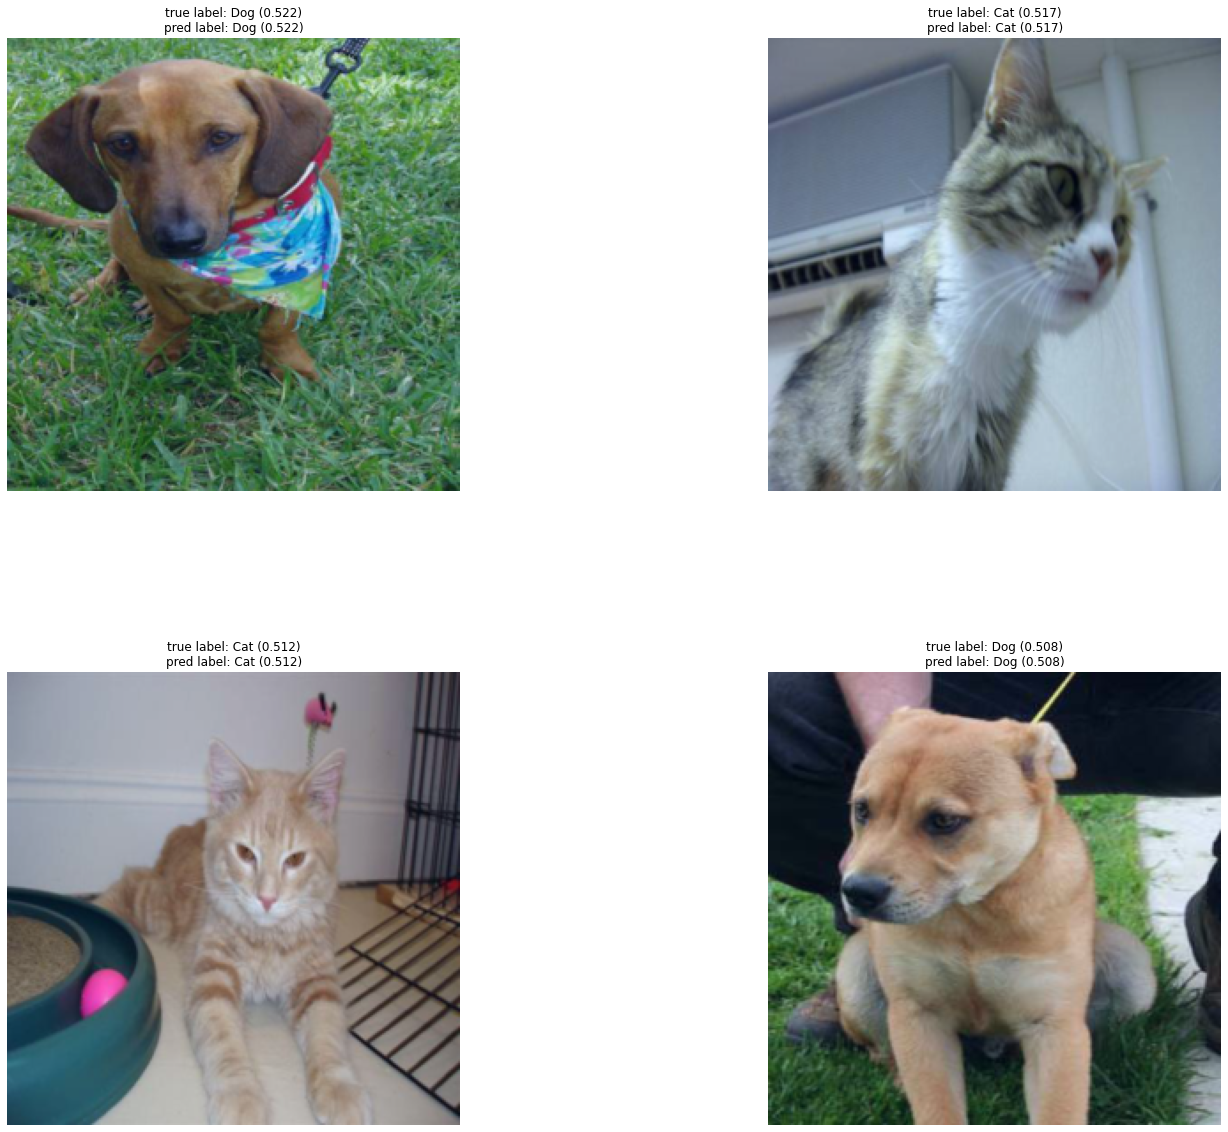

In [35]:
import matplotlib.pyplot as plt
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)